In [20]:
import pandas as pd
from glob import glob
import os
import numpy as np
import re
import sys
from collections import defaultdict
import itertools
sys.path.append('utils/')
from airforce_python_scraper import states
import calendar
from fuzzywuzzy import fuzz
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
sapro_full = pd.read_excel('sapro_full.xlsx')

In [3]:
sapro_full['Outcome'].value_counts()

no court-martial    6042
guilty              1536
not guilty           785
Name: Outcome, dtype: int64

In [4]:
fn = '../data/final_usm_data/size-of-usm-by-rank/DRS_42486_Active Duty_FY2014.xlsx'
num_active_duty_2014 = pd.ExcelFile(fn)
sheets_2014 = num_active_duty_2014.sheet_names

fn = '../data/final_usm_data/size-of-usm-by-rank/DRS_42486_Active Duty_FY2015.xlsx'
num_active_duty_2015 = pd.ExcelFile(fn)
sheets_2015 = num_active_duty_2015.sheet_names

In [5]:
output = {}

for year in ['2014','2015']:
    for sheet in eval('sheets_%s' % year):
        sheet_date = sheet.split(' - ')[1]
        t = eval("num_active_duty_%s" % year).parse(sheet)
        df = (t.loc[6:31]
              .set_index('Department of Defense')
              .drop([np.nan, 'TOTAL OFFICER']).sum(axis=1)
             )
        output[sheet_date] = df

In [6]:
full_enlisted_df = pd.DataFrame(output)

In [7]:
ordering = ["Cadet", "E-1", "E-2", "E-3", "E-4", "E-5", "E-6", 
 "E-7", "E-8", "E-9", "W-1", "W-2", "W-3", "W-4", "W-5", 
 "O-1", "O-2", "O-3", "O-4", "O-5", "O-6", "O-7", "O-8",
 "O-9", "O-10",]

In [8]:
mapping = {
"GENERAL       -ADMIRAL": "O-10",
"LT GENERAL    -VICE ADMIRAL": 'O-9',
"MAJ GENERAL   -REAR ADMIRAL(U)" : "O-8",
"BRIG GENERAL  -REAR ADMIRAL(L)": "O-7",
"COLONEL       -CAPTAIN": "O-6",
"LIEUTENANT COL-COMMANDER": "O-5",
"MAJOR         -LT COMMANDER": "O-4",
"CAPTAIN       -LIEUTENANT": "O-3",
"Ist LIEUTENANT-LIEUTENANT(JG)": "O-2",
"2nd LIEUTENANT-ENSIGN": "O-1",
"CHIEF WARRANT OFFICER W-5":"W-5",
"CHIEF WARRANT OFFICER W-4":"W-4",
"CHIEF WARRANT OFFICER W-3":"W-3",
"CHIEF WARRANT OFFICER W-2":"W-2",
"WARRANT OFFICER W-1":"W-1",
"E-9":"E-9",
"E-8":"E-8",
"E-7":"E-7",
"E-6":"E-6",
"E-5":"E-5",
"E-4":"E-4",
"E-3":"E-3",
"E-2":"E-2",
"E-1":"E-1",}

In [9]:
full_enlisted_df = (full_enlisted_df
 .reset_index()
 .assign(pay_grade = lambda df: df['Department of Defense'].apply(lambda x: mapping[x] ))
 .drop('Department of Defense', axis=1)
 .set_index('pay_grade')
)

#### Total SAPRO Records

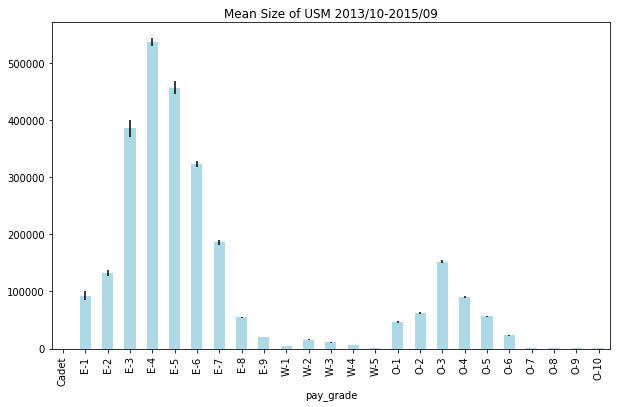

In [16]:
full_enlisted_df.reindex(index=ordering).pipe(lambda df: 
    df.mean(axis=1).plot(
        kind='bar',
        yerr=df.std(axis=1),
        title='Mean Size of USM 2013/10-2015/09',
        figsize=(10,6),
        color='lightblue'
    )
)

In [17]:
to_drop = [
    'Cadet/Mid shipman',
    'Foreign National',
    'Subject Pay Grade',
    'UNKNOWN', 'Unknow','Unknown',
    'US Civilian',
    "C-1","C-2","C-3","C-4",
    "M-1","M-2","M-3"
]
intermediate_sapro_ranks = (sapro_full
 [['Subject Pay Grade', 'Outcome']]
 .assign(c=1)
 .pivot_table('c', 'Subject Pay Grade', 'Outcome', aggfunc='sum')
 .sort_index()
 .drop(to_drop)
)

In [18]:
normed_overall_counts = (intermediate_sapro_ranks
                 .fillna(0)
                 .apply(lambda x: x/ full_enlisted_df.mean(axis=1))
                 .fillna(0)
                 .loc[ordering]
                )

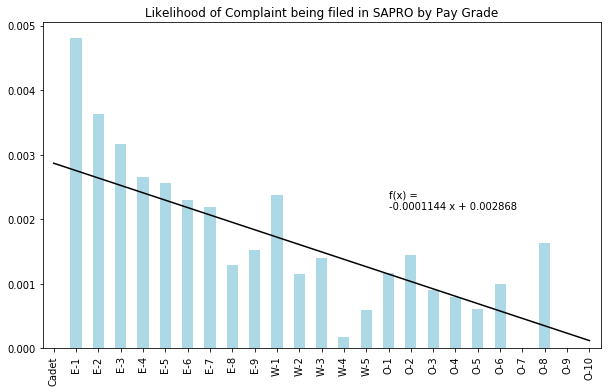

In [21]:
(normed_overall_counts
 .sum(axis=1)
 .plot(kind='bar', figsize=(10,6), color='lightblue')
)
plt.title('Likelihood of Complaint being filed in SAPRO by Pay Grade')

x, y = range(len(normed_overall_counts)), normed_overall_counts.sum(axis=1).values
fit = np.poly1d(np.polyfit(x, y, 1))
plt.plot(np.unique(x), fit(np.unique(x)), color='black')
plt.text(x[-10], fit(x[-10])+ .001, 'f(x) = ' + str(fit));

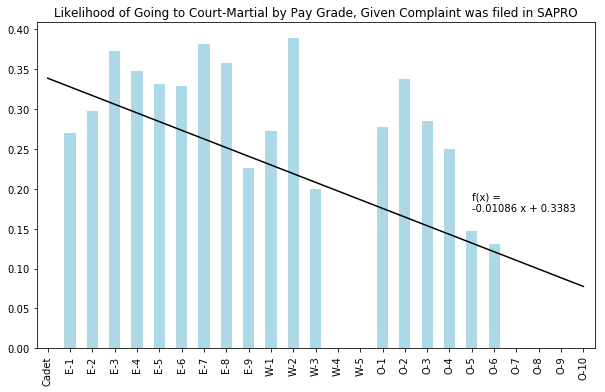

In [380]:
court_martial_likelihood = (
    normed_overall_counts.pipe(lambda df: (df['guilty'] + df['not guilty']) / df.sum(axis=1))
                 .fillna(0)
                 .loc[ordering]
)
court_martial_likelihood.plot(kind='bar', figsize=(10,6), color='lightblue')
plt.title('Likelihood of Going to Court-Martial by Pay Grade, Given Complaint was filed in SAPRO')
x, y = range(len(court_martial_likelihood)), court_martial_likelihood.values
fit = np.poly1d(np.polyfit(x, y, 1))
plt.plot(np.unique(x), fit(np.unique(x)), color='black')
idx = -6
plt.text(x[idx], fit(x[idx])+ .04, 'f(x) = ' + str(fit));

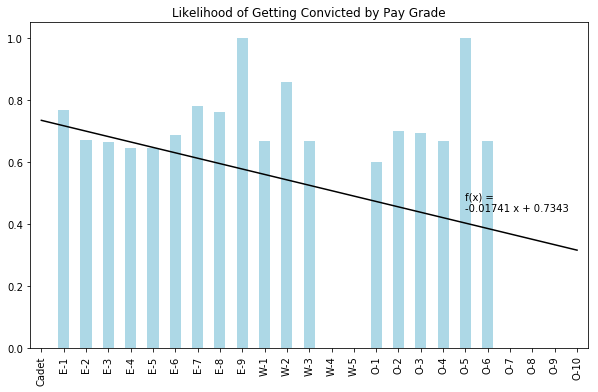

In [381]:
conviction_likelihood = (
    normed_overall_counts.pipe(lambda df: df['guilty']/ (df['guilty'] + df['not guilty']) )
                 .fillna(0)
                 .loc[ordering]
                )
conviction_likelihood.plot(kind='bar', figsize=(10,6), color='lightblue')
plt.title('Likelihood of Getting Convicted by Pay Grade')
x, y = range(len(conviction_likelihood)), conviction_likelihood.values
fit = np.poly1d(np.polyfit(x, y, 1))
plt.plot(np.unique(x), fit(np.unique(x)), color='black')
idx = -6
plt.text(x[idx], fit(x[idx])+ .04, 'f(x) = ' + str(fit));

# By Grouping

In [28]:
from scipy.stats import chi2_contingency

In [30]:
groupings = {
'low-enlisted': ['E-1', 'E-2', 'E-3', 'E-4'],
'mid-enlisted': ['E-5', 'E-6'],
'high-enlisted': ['E-7', 'E-8', 'E-9'],
'warrant': ['W-1', 'W-2', 'W-3', 'W-4', 'W-5'],
'low-officer':['O-1','O-2','O-3'],
'mid-officer':['O-4', 'O-5', 'O-6'],
'high-officer':['O-7', 'O-8', 'O-9', 'O-10']
}

grade_to_grouping = {}
for group, items in groupings.items():
    for item in items:
        grade_to_grouping[item] = group

grade_to_grouping = pd.Series(grade_to_grouping).to_frame('group')
grouped_ranks= (intermediate_sapro_ranks
                .merge(grade_to_grouping, left_index=True, right_index=True)
                .groupby('group')
                .sum()
)
grouped_size = (
    full_enlisted_df
        .mean(axis=1)
        .to_frame('size')
        .merge(grade_to_grouping, left_index=True, right_index=True)
        .groupby('group')
        .sum()
)
group_ordering = ["low-enlisted",
"mid-enlisted",
"high-enlisted",
"warrant",
"low-officer",
"mid-officer",
"high-officer",]

normed_groups = (grouped_ranks
                  .apply(lambda x: x/ grouped_size['size'])
                  .loc[group_ordering])

In [44]:
(grouped_ranks
 .sum(axis=1)
 .loc[group_ordering]
 .to_frame("Count Of Complaints")
 .merge(right=grouped_size, left_index=True, right_index=True)
).T

group,low-enlisted,mid-enlisted,high-enlisted,warrant,low-officer,mid-officer,high-officer
Count Of Complaints,3568.00,1911.000000,508.000000,46.000000,280.000000,129.000000,1.000000
size,1146807.25,779600.416667,260723.583333,38372.666667,259638.916667,169417.333333,1813.583333


In [58]:
((grouped_ranks
 .sum(axis=1)
 .loc[group_ordering]
 .to_frame("Count Of Complaints")
 .merge(right=grouped_size, left_index=True, right_index=True)
).T
 .pipe(lambda df: pd.concat([
        df[filter(lambda x: 'enlisted' in x, df.columns)].sum(axis=1).to_frame('enlisted'),
        df[filter(lambda x: 'officer' in x, df.columns)].sum(axis=1).to_frame('officer')
    ], axis=1))
 .pipe(lambda df: df.loc['Count Of Complaints']/df.loc['size'])
)

enlisted    0.002737
officer     0.000952
dtype: float64

# investigate the language used in case notes for higher-ranking officers

In [66]:
officer_sapro = sapro_full.loc[lambda df: df.fillna('')['Subject Pay Grade'].apply(lambda x: 'O' in x)]
enlisted_sapro = sapro_full.loc[lambda df: df.fillna('')['Subject Pay Grade'].apply(lambda x: 'E' in x)]

In [79]:
(officer_sapro['Victim Gender']
 .apply(lambda x: 'Multiple' if 'Multiple' in x else x)
 .value_counts()
 .pipe(lambda s: s/s.sum())
)

Female      0.763658
Male        0.203682
Multiple    0.022565
Unknown     0.009501
Q1          0.000594
Name: Victim Gender, dtype: float64

In [78]:
(enlisted_sapro['Victim Gender']
 .apply(lambda x: 'Multiple' if 'Multiple' in x else x)
 .value_counts()
 .pipe(lambda s: s/s.sum())
)

Female                    0.788208
Male                      0.123434
Multiple                  0.071822
Unknown                   0.015534
Female, Female, Female    0.000334
Female, Female            0.000334
Male, Male                0.000167
Female,                   0.000167
Name: Victim Gender, dtype: float64

In [96]:
import string

In [109]:
from sklearn.feature_extraction.text import CountVectorizer

In [110]:
cv = CountVectorizer(stop_words="english")

In [111]:
def repl_punc(x):
    for punc in string.punctuation:
        x = x.replace(punc, " ")
    return x

In [115]:
words = cv.fit_transform(pd.concat([
    (enlisted_sapro
     .pipe(lambda df: df['Case Synopsis'].fillna('') + df['Case Synopsis'].fillna(''))
     .apply(repl_punc)
        )
        ,
    (officer_sapro
     .pipe(lambda df: df['Case Synopsis'].fillna('') + df['Case Synopsis'].fillna(''))
     .apply(repl_punc)
    )
]))

In [120]:
word_df = pd.DataFrame(words.todense(), columns=pd.Series(cv.vocabulary_).index)

In [123]:
enlisted_sapro_words = word_df.loc[:len(enlisted_sapro)]

In [124]:
officer_sapro_words = word_df.loc[len(enlisted_sapro): ]

In [132]:
enlisted_sapro_words.sum().sort_values(ascending=False).head()

victim     1378
subject    1322
pay        1050
yes        1004
alleged     966
dtype: int64

In [133]:
officer_sapro_words.sum().sort_values(ascending=False).head()

subject    321
victim     284
alleged    262
notes      248
assault    146
dtype: int64

In [134]:
e_counts = enlisted_sapro_words.sum()

In [135]:
o_counts = officer_sapro_words.sum()

In [185]:
top_words = (word_df
             .sum()
             .loc[lambda s: s>5]
             .index)

In [186]:
p_word_lift = (
    e_counts.pipe(lambda s: s/s.sum()).loc[top_words] / 
    o_counts.pipe(lambda s: s/s.sum()).loc[top_words]
).replace([-np.inf, np.inf], np.nan).dropna().sort_values()

In [187]:
1/p_word_lift.iloc[:35]

elimination          inf
foreign              inf
workplace            inf
bus                  inf
barred               inf
national       53.417130
dismissal      47.693866
unbecoming     38.155093
known          26.708565
sent           22.893056
unknown        18.653601
arm            15.262037
police         15.262037
threatening    15.262037
naked          15.262037
board          11.446528
shoulders      11.446528
officer        10.174692
male            7.631019
legs            7.631019
superior        7.631019
office          7.631019
leg             7.631019
discharged      7.631019
authority       7.631019
photos          7.631019
500             7.631019
hugged          5.087346
assault         4.761234
written         4.578611
unwanted        4.239455
impaired        3.815509
fellatio        3.815509
dance           3.815509
testify         3.815509
dtype: float64

In [189]:
p_word_lift.iloc[-45:]

asleep               1.834617
pay                  1.859410
30                   1.878299
sex                  1.965662
trial                1.965662
14                   2.037140
did                  2.096706
raped                2.096706
vulva                2.096706
days                 2.173148
yes                  2.268419
tf                   2.358794
maltreatment         2.358794
oth                  2.467997
incapacitated        2.489838
multiple             2.489838
discharge            2.507708
administrative       2.555360
intoxicated          2.686404
committed            2.686404
12c                  2.751926
court                2.817448
fg                   2.882970
gcm                  2.915731
party                3.014014
chapter              3.145058
insufficient         3.669235
genitals             3.669235
barracks             3.800279
100                  3.996845
45                   4.127889
charges              4.237093
administratively     4.258933
lieu      

In [210]:
officer_top_words = [
    "threatening", 
#     "assault",
]# "unwanted", "impaired", "dance"]
enlisted_top_words = ["party", "intoxicated"]
secondary_enlisted_list = ["separated", "genitals"]

In [206]:
officer_sapro = officer_sapro.assign(results=lambda df: df['Case Synopsis'].fillna('') + df['Case Synopsis Note'].fillna(''))
enlisted_sapro = enlisted_sapro.assign(results=lambda df: df['Case Synopsis'].fillna('') + df['Case Synopsis Note'].fillna(''))

In [220]:
(officer_sapro['results']
 .loc[lambda s: s.fillna('').apply(lambda r: any(map(lambda x: x in r.lower(), officer_top_words)))]
).iloc[3]

u'Notes: Cadet Victim alleged that Subject forced her to engage in sex acts by threatening her career. Subject died (natural causes) prior to allegations being reported.'

In [225]:
(enlisted_sapro['results']
 .loc[lambda s: s.fillna('').apply(lambda r: any(map(lambda x: x in r.lower(), enlisted_top_words)))]
).iloc[25]

u'Notes: Victim reported that Subject sexually assaulted him by touching his penis while the victim was too intoxicated to consent. Subject pled guilty in civilian court to Battery, receving three years probation. After consultation with the SJA, the Subject was administratively separated with an Other than Honorable.'

([<matplotlib.axis.YTick at 0x115e09ed0>,
 <a list of 7 Text yticklabel objects>)

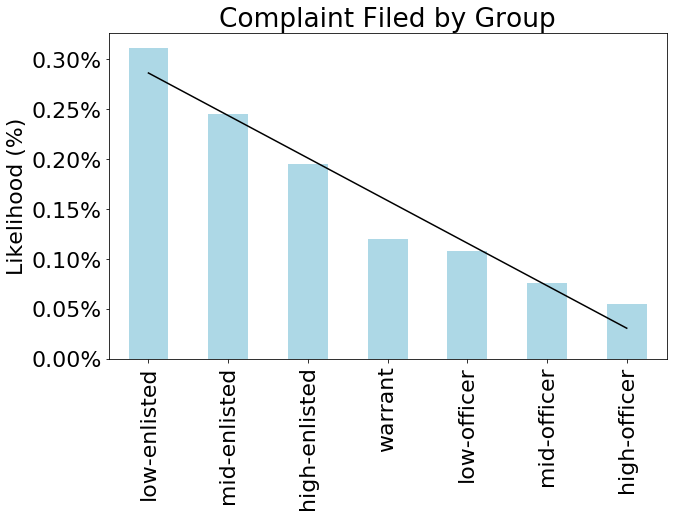

In [120]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', size=22)
normed_groups.sum(axis=1).plot(kind='bar', figsize=(10,6), color='lightblue')
plt.title('Complaint Filed by Group')

x, y = range(len(normed_groups)), normed_groups.sum(axis=1).values
fit = np.poly1d(np.polyfit(x, y, 1))
plt.plot(np.unique(x), fit(np.unique(x)), color='black')
plt.xlabel('')

plt.ylabel('Likelihood (%)')
y_ticks = plt.yticks()[0][:-1]
plt.yticks(
    list(y_ticks),
    ['%.02f' % (item*100) + '%' for item in  y_ticks]
)



([<matplotlib.axis.YTick at 0x119e2a510>,
 <a list of 4 Text yticklabel objects>)

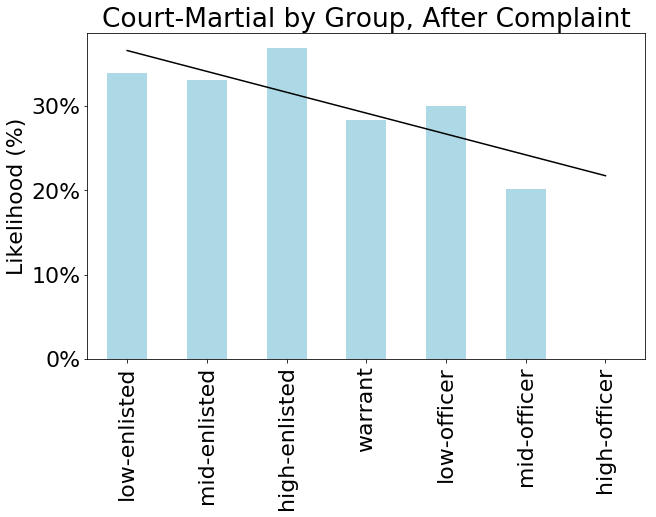

In [111]:
t = (normed_groups
 .pipe(lambda df: (df['guilty'] + df['not guilty']) / df.sum(axis=1))
 .fillna(0)
    )
t.plot(kind='bar', figsize=(10,6), color='lightblue')
plt.title('Court-Martial by Group, After Complaint')

t = t[t!=0]
x, y = range(len(t)), t.values
fit = np.poly1d(np.polyfit(x, y, 1))
plt.plot(x + [6], fit(x + [6]), color='black')
plt.xlabel('')

plt.ylabel('Likelihood (%)')
y_ticks = plt.yticks()[0][:-1]
plt.yticks(
    list(y_ticks),
    [str(int(item*100)) + '%' for item in  y_ticks]
)

# idx = -3
# plt.text(x[idx], fit(x[idx])+.0001, 'f(x) = ' + str(fit));

Text(0,0.5,'Likelihood (%)')

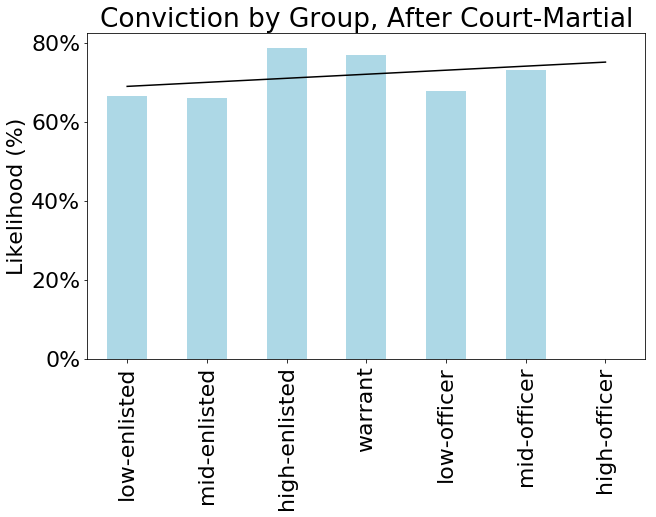

In [121]:
t = (normed_groups
 .pipe(lambda df: df['guilty']/ (df['guilty'] + df['not guilty']) )).fillna(0)
t.plot(kind='bar', figsize=(10,6), color='lightblue')
plt.title('Conviction by Group, After Court-Martial')

t = t[t!=0]
x, y = range(len(t)), t.values
fit = np.poly1d(np.polyfit(x, y, 1))
plt.plot(x + [6], fit(x + [6]), color='black')
plt.xlabel('')

y_ticks = plt.yticks()[0][:-1]
plt.yticks(
    list(y_ticks),
    [str(int(item*100)) + '%' for item in  y_ticks]
)
plt.ylabel('Likelihood (%)')

# idx = -3
# plt.text(x[idx], fit(x[idx])+.0001, 'f(x) = ' + str(fit));

/Users/206309/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/206309/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


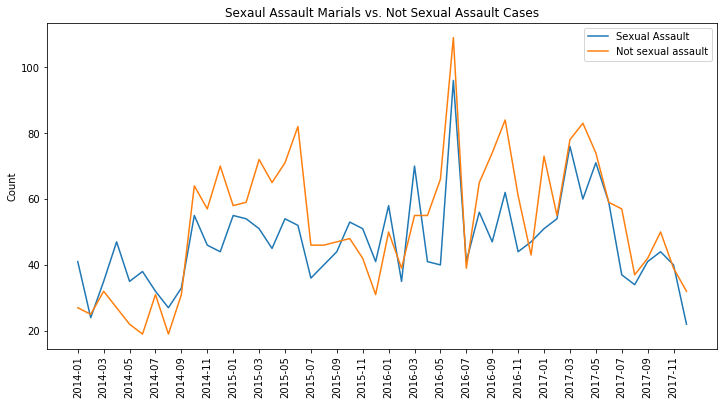

In [73]:
%matplotlib inline
import matplotlib.pyplot as plt

t=  pd.concat([
    (summary_full
     [summary_full['Year'].isin(['2014', '2015', '2016', '2017'])]
     [summary_full['Sexual-assault?'] ==True]
     ['Date-clean']
     .value_counts()
     .to_frame('Sexual Assault')
    ).sort_index(),
    (summary_full
     [summary_full['Year'].isin(['2014', '2015', '2016', '2017'])]
     [summary_full['Sexual-assault?'] ==False]
     ['Date-clean']
     .value_counts()
     .to_frame('Not sexual assault'))
    .sort_index()
], axis=1)

t.plot(figsize=(12,6))
plt.xticks(range(len(t))[::2], list(t.index)[::2], rotation='vertical')
plt.title('Sexaul Assault Martials vs. Not Sexual Assault Cases')
plt.ylabel('Count');

/Users/206309/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/206309/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


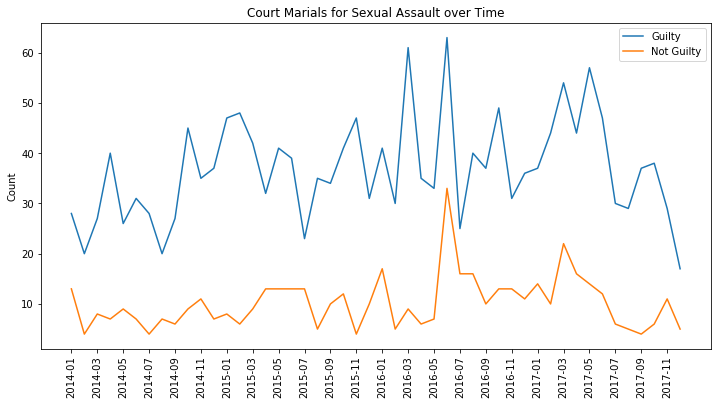

In [65]:
%matplotlib inline
import matplotlib.pyplot as plt

t=  pd.concat([
    (summary_sex_assault_full
     [summary_sex_assault_full['Year'].isin(['2014', '2015', '2016', '2017'])]
     [summary_sex_assault_full['Conclusion'] =='guilty']
     ['Date-clean']
     .value_counts()
     .to_frame('Guilty')
    ).sort_index(),
    (summary_sex_assault_full
     [summary_sex_assault_full['Year'].isin(['2014', '2015', '2016', '2017'])]
     [summary_sex_assault_full['Conclusion'] =='not guilty']
     ['Date-clean']
     .value_counts()
     .to_frame('Not Guilty'))
    .sort_index()
], axis=1)

t.plot(figsize=(12,6))
plt.xticks(range(len(t))[::2], list(t.index)[::2], rotation='vertical')
plt.title('Court Marials for Sexual Assault over Time')
plt.ylabel('Count');

In [88]:
pd.read_csv(StringIO(rank_by_year) , sep='\t', names=['Rank','2016','2017','2018'])

,Rank,2016,2017,2018
0,General (O10),13,14,14
1,Lieutenant General (O9),40,41,42
2,Major General (O8),91,97,92
3,Brigadier General (O7),153,145,149
4,Colonel (O6),"3,320","3,395","3,415"
5,Lieutenant Colonel (O5),"9,585","9,812","10,011"
6,Major (O4),"12,902","13,488","13,396"
7,Captain (O3),"21,252","21,010","21,577"
8,1st Lieutenant (O2),"6,901","6,787","6,781"
9,2nd Lieutenant (O1),"6,704","6,909","6,974"


In [ ]:
pd.read_csv()

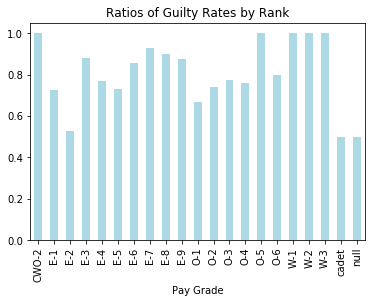

In [52]:
(conviction_by_pay_grade
 .fillna(0)
 .pipe(lambda df: df['guilty'] / (df['guilty'] + df['not guilty']))
 .plot(kind='bar', color='lightblue')
)
plt.title('Ratios of Guilty Rates by Rank')

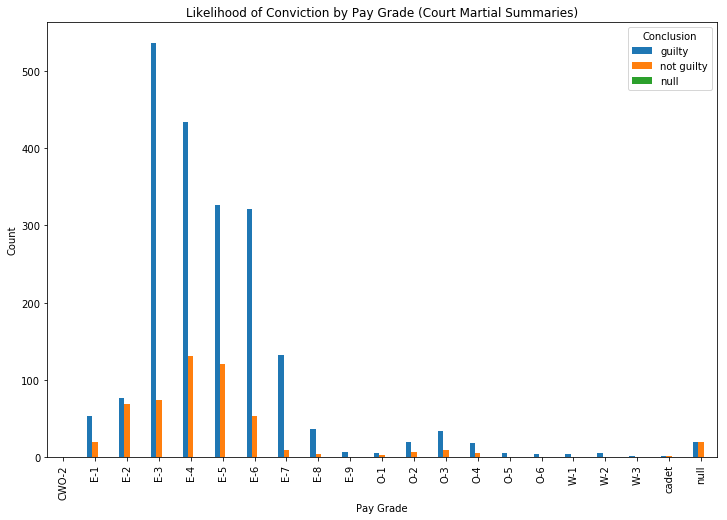

In [45]:
conviction_by_pay_grade = (summary_sex_assault_full
 [['Pay Grade', 'Conclusion']]
 .assign(c=1)
 .pivot_table('c', 'Pay Grade', 'Conclusion', aggfunc='sum')
#  .pipe(lambda df: df.fillna(0))
#  .pipe(lambda df: df['guilty'] / (df['guilty'] + df['not guilty']) )
 .sort_index())
conviction_by_pay_grade.plot(kind='bar', figsize=(12,8))

plt.title('Likelihood of Conviction by Pay Grade (Court Martial Summaries)')
plt.ylabel('Count');

In [468]:
sapro_full[[
    'Must Register as Sex Offender',
    'Administrative Discharge Type',
    'Adverse Administrative Action Type',
    'Extra Duty',
    'Fines and Forfeiture s',
    'Hard Labor'
]].head(10)

,Must Register as Sex Offender,Administrative Discharge Type,Adverse Administrative Action Type,Extra Duty,Fines and Forfeiture s,Hard Labor
0,null,General,null,YES,YES,null
1,null,General,null,null,null,null
2,null,General,null,null,null,null
3,null,Pending,null,null,null,null
4,null,Uncharacterized,null,null,null,null
5,null,Uncharacterized,null,null,null,null
6,null,UOTHC,null,null,null,null
7,null,General,null,null,null,null
8,null,General,null,null,null,null
9,null,General,null,YES,YES,null


# Get and clean data

In [71]:
sapro_tables = [(pd.read_excel(path)
         .assign(Year='20' + re.search('\d\d', path).group())
) for path in glob('../data/intermediate_usm_data/sapro/SAPRO Annual Reports/SAPRO_*_all.xlsx')
                + ['../data/intermediate_usm_data/sapro/SAPRO Annual Reports/SAPRO_charts_army_14.xlsx']
]

def clean_colname(col):
    return (col.replace('\r', ' ')
                  .replace('Administra- tive Discharge Type', 'Administrative Discharge Type')
                  .replace('Confinemen t', 'Confinement')
                  .replace('Incident Location', 'Location')
                  .replace('Quarter Dispositio n Complete d', 'Quarter Disposition Completed')
                  .replace('applicable.', 'applicable')
                  .replace('Acession ?', 'Acession?')
                  .replace('Restrictio n', 'Restriction')
                  .replace('Investi- gation', 'Investigation')
                  .replace('Victim Grade', 'Victim Pay Grade')
                  .replace('Subject Grade', 'Subject Pay Grade')
                  .replace('Subject Affiliation', 'Subject Service')
                  )

cleaned_tables = [table.rename(
    columns={col:clean_colname(col) for col in table.columns}
) for table in sapro_tables]

sapro_full = pd.concat(cleaned_tables).reset_index(drop=True)
sapro_full = sapro_full.applymap(lambda x: x.replace('\r', ' ') if isinstance(x, basestring) else x)

summary_tables = [
    pd.read_csv(path,index_col=0).assign(division=os.path.basename(path).split('_')[0])
    for path in glob('../data/final_usm_data/court_martial_summaries/*')
]
summary_tables = map(lambda table: table.rename(columns={
    col: col.replace('date', 'Date').title() for col in table.columns
}), summary_tables)
summary_full = pd.concat(summary_tables).reset_index(drop=True)

# get rank table
rank_mapping_table = pd.read_csv('../data/final_usm_data/rank-mapping.csv')[['Branch', 'Rank', 'Standardized Pay Grade']]
rank_mapping_table = rank_mapping_table.set_index('Branch')

###### normalize rank
ranks = (summary_full
 .groupby('Division')['Rank']
 .apply(lambda x: x.value_counts())
 .reset_index()
 .iloc[:, :2]
 .rename(columns={'level_1': 'Rank'})
)

def normalize_rank(row):
    if pd.notnull(row['Rank']):
        branch = rank_mapping_table.loc[row['Division']]
        grade = branch[branch['Rank'] ==  row['Rank']]['Standardized Pay Grade'].unique()
        if len(grade) == 1:
            return grade[0]
    return np.nan

summary_full['Pay Grade'] = summary_full.apply(normalize_rank, axis=1)

########## normalize date
summary_full['Date'] = summary_full.apply(lambda x: x['Date'] if pd.notnull(x['Date']) else x['Document'], axis=1)

def get_year(date_val):
    if isinstance(date_val, basestring):
        full = re.search('\d{4}', date_val)
        if full:
            return full.group()
        small = re.search('\d{2}', date_val)
        if small:
            return '20' + small.group()
    return np.nan

summary_full['Year'] = summary_full['Date'].apply(get_year)

## get court martials that have to do with sexual assault
summary_sex_assault_full = summary_full[(summary_full['Offense'].apply(lambda x: 
    (('sex' in x)
     or ('rape' in x)
     or ('raping' in x)
     or ('assault' in x)
     or ('120' in x)
#      or ('134' in x)
     or ('indecent visual recording' in x)
     or ('lawful general order' in x)
#      or ('128' in x)
 ) if pd.notnull(x) else False))].copy()

summary_full['Sexual-assault?'] = (summary_full['Offense'].apply(lambda x: 
    (('sex' in x)
     or ('rape' in x)
     or ('raping' in x)
     or ('assault' in x)
     or ('120' in x)
#      or ('134' in x)
     or ('indecent visual recording' in x)
     or ('lawful general order' in x)
#      or ('128' in x)
 ) if pd.notnull(x) else False)).copy()

def clean_conclusion(row):
    if row['Conclusion'] == 'not guilty':
        if (row.fillna('null')['Sentence'] != 'null'):
            return 'guilty'
    return row['Conclusion']
 
summary_sex_assault_full['Conclusion'] = (summary_sex_assault_full
                      .apply(clean_conclusion, axis=1))

exact_matches = pd.DataFrame([
    {"type": "Service", "SAPRO": "Subject Service", "SUMMARIES": "Division"},
    {"type": "Year", "SAPRO": "Year", "SUMMARIES": "Year"},
    {"type": "Rank", "SAPRO": "Subject Pay Grade", "SUMMARIES": "Pay Grade"},
#     {"type": "Country", "SAPRO": "Location", "SUMMARIES": "Country"},
    {"type": "Gender", "SAPRO": "Subject Gender", "SUMMARIES": "Gender"},
    {"type": "Case_outcome", "SAPRO": "Outcome", "SUMMARIES": "Conclusion"}
]).set_index("type")


def clean_sapro_service(service_elem):
    if pd.notnull(service_elem):
        return (service_elem
         .replace('(', '').replace(')', '')
         .replace(' Corps', 's')
         .replace('Air Force', 'AirForce')
         .strip()
         .upper()
    ) 
def clean_summaries_countries(country_row):
    if pd.notnull(country_row):
        country_row = (country_row
         .replace(' a', '')
         .replace('(',''). replace(')', '')
         .replace('U.S.A.', 'USA')
         .replace('MCRD San Diego', 'USA')
         .replace('Calfornia', 'USA')
         .replace('D.C.', 'USA')
      )  
        if country_row in states:
            country_row = 'USA'
        return country_row.upper()

def clean_sapro_country(country_row):
    if pd.notnull(country_row):
        country_row = (country_row.upper()
         .replace('OCONUS', 'USA')
         .replace('CONUS', 'USA')
         .replace('UNITED STATES', 'USA')
         .replace('AFGHANIST AN', 'AFGHANISTAN')
         .replace('AFGHANISTA N', 'AFGHANISTAN')
         .replace('UNKNOW N', 'UNKNOWN')
        )
        if country_row == 'AFGHANISTA':
            country_row = 'AFGHANISTAN'
        if country_row in states:
            country_row = 'USA'
        if country_row == 'US':
            country_row = 'USA'
        if country_row == 'UK':
            country_row = 'United Kingdom'
        if country_row == 'CA,MD':
            country_row = 'USA'
        return country_row.upper()

def sapro_get_court_martial_outcome(row):
    if pd.notnull(row):
        row = row.lower()
        if row !='null':
            if ('dismissed' in row) or ('acquit' in row):
                if ('subsequent' in row) or ('prior' in row):
                    outcome = 'no court-martial'
                else:
                    outcome = 'not guilty'
            elif ('in lieu' in row) or ('article 15' in row) or ('art 15' in row):
                outcome = 'no court-martial'
            else:
                outcome = 'guilty'
            return outcome
    return 'no court-martial'

sapro_full['Subject Service'] = sapro_full['Subject Service'].apply(clean_sapro_service)
summary_sex_assault_full['Country'] = (summary_sex_assault_full['Country']
                                       .apply(
    clean_summaries_countries
))
sapro_full['Location'] = sapro_full['Location'].apply(clean_sapro_country)
sapro_full['Location'] = sapro_full['Location'].apply(clean_sapro_country)
sapro_full['Outcome'] = sapro_full['Court Case or Article 15 Outcome'].apply(
    sapro_get_court_martial_outcome
)
sapro_full['Subject Gender'] = sapro_full['Subject Gender'].apply(
    lambda x: x.lower() if pd.notnull(x) else x
)


summary_sex_assault_full = (summary_sex_assault_full
.applymap(lambda x: unicode(x, encoding='utf-8') if pd.notnull(x) else x)
)

def clean_subject_service(row):
    if pd.isnull(row['Subject Service']):
        if pd.notnull(row['Case Disposition']):
            if row['Case Disposition'] in [
                'Civilian or Foreign Prosecution of Person Not Subject to UCMJ',
                'Unknown Subject',
                'Civilian or Foreign Prosecution of Person Not Subject to',
                'Offender is Unknown',
                'Subject is a Civilian or Foreign National',
                'Unknown']:
                return 'UNKNOWN'
    else:
        return row['Subject Service']

sapro_full['Subject Service'] = sapro_full.apply(clean_subject_service, axis=1)
sapro_full['Subject Pay Grade'] = (sapro_full
   .apply(lambda x: 'UNKNOWN' if  x['Subject Service'] == 'UNKNOWN' else x['Subject Pay Grade']
, axis=1))

import gender_guesser.detector as gender
d = gender.Detector()

def summary_get_gender(row):    
    male_names = ['Alexzander','Frankey','Marckus','Frankey','Jeffary','Juventino',
                  'Jerard','Trentlee','Jarrid','Nehral','Keidrick','Leather','Alexeiv',
                  'Kirkland','Darris',u'Tyrus',u'Cooney', 'Edmourd',
                  'Terance','Vincell','Deandrea','Casey']
    
    gender = row['Gender']
    if pd.isnull(gender):
        if isinstance(row['Name'], basestring) and (row['Name'] != 'null'):
            for name in row['Name'].split(' '):
                if name in male_names:
                    gender = 'male'
                    break
                d_gender = d.get_gender(name)
                d_gender = d_gender.replace('mostly_', '')
                if d_gender in ['male', 'female']:
                    gender = d_gender
                    break
    
    return gender

summary_sex_assault_full['Gender'] = summary_sex_assault_full.apply(summary_get_gender, axis=1)
summary_sex_assault_full.isnull().apply(lambda x: x.value_counts())[list(exact_matches['SUMMARIES'])]

month_mapping = {v:k for k,v in enumerate(list(calendar.month_abbr))}
month_mapping.update( {v.upper():k for k,v in enumerate(list(calendar.month_abbr))})
month_re = '|'.join(map(lambda x: x.upper(), list(calendar.month_abbr)[1:] )+ list(calendar.month_abbr)[1:])

def get_month(date_val):
    if re.match('\d{1,2}/\d{1,2}/\d\d\d\d', date_val):
        return date_val.split('/')[0]
    month_match = re.search(month_re, date_val)
    if month_match:
        return month_mapping[month_match.group()]
        
# def get_year(date_val):
#     if isinstance(date_val, basestring):
#         full = re.search('\d{4}', date_val)
#         if full:
#             return full.group()
#         small = re.search('\d{2}', date_val)
#         if small:
#             return '20' + small.group()
#     return np.nan
# if pd.notnull()

summary_full['Month'] = summary_full['Date'].fillna('').apply(get_month)
summary_full['Date-clean'] = (summary_full[['Month','Year']]
                                          .replace('null',np.nan)
                                          .apply(
                      lambda x: '%04d-%02d' % (int(x['Year']), int(x['Month']))
                          if pd.notnull(x).any() else np.nan, axis=1)
                                         )

summary_sex_assault_full['Month'] = summary_sex_assault_full['Date'].fillna('').apply(get_month)
summary_sex_assault_full['Date-clean'] = (summary_sex_assault_full
                                          [['Month','Year']]
                                          .replace('null',np.nan)
                                          .apply(
                      lambda x: '%04d-%02d' % (int(x['Year']), int(x['Month']))
                          if pd.notnull(x).any() else np.nan, axis=1)
                                         )